<a href="https://colab.research.google.com/github/nebojsa-bozanic/OSuM/blob/master/OSuM_Vezba12/OSuM_Vezba12/OSuM_vezba_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Obrada slike u medicini (BMI)</h1>

Literatura: https://moodle.telekom.ftn.uns.ac.rs/course/view.php?id=82


Laboratorijska vežba 12: Perspektivne transformacije i kruta registracija

Potrebne biblioteke: cv2, numpy, matplotlib.pyplot, osum

In [ ]:
!git clone https://github.com/nebojsa-bozanic/OSuM.git
%cd /content/OSuM/OSuM_Vezba12/OSuM_Vezba12

fatal: destination path 'OSuM' already exists and is not an empty directory.
/content/OSuM/OSuM_Vezba12/OSuM_Vezba12


In [ ]:
import cv2
import osum
import matplotlib.pyplot as plt
import numpy as np

# 1. Odabiranje (interpolacija) referentnog regiona za registraciju

1.1 U promenljivu r učitati referentnu sliku REG_HE.png, a u promenljivu t učitati test sliku po izboru REG_LE_0X.PNG. Prikazati slike. Sve test slike su translirane po x i/ili y-osi u odnosu na referentnu.

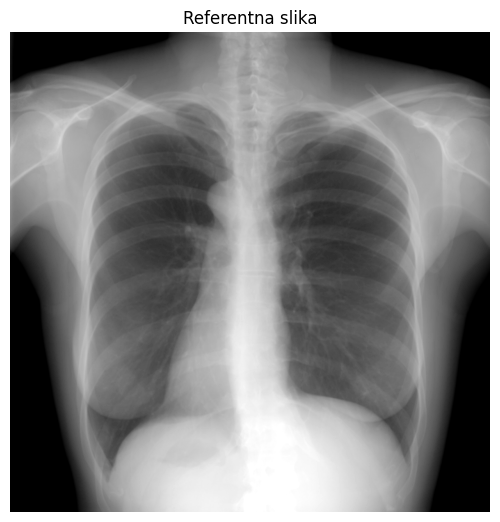

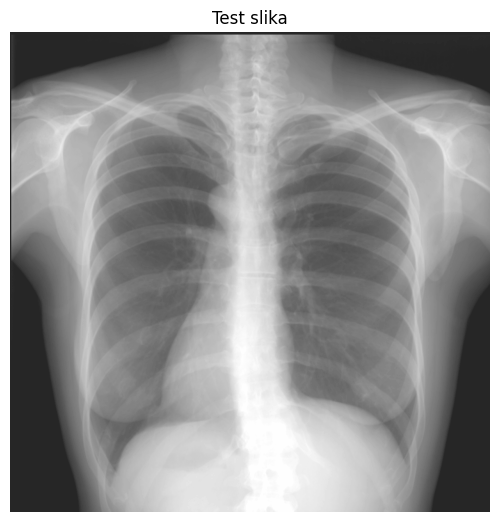

In [ ]:
# 1.1
r = cv2.imread('RAD_HE.png', cv2.IMREAD_GRAYSCALE)
t = cv2.imread('REG_LE_01.PNG', cv2.IMREAD_GRAYSCALE)

osum.disp_im(r, title='Referentna slika')
osum.disp_im(t, title='Test slika')
plt.show()

1.2 Izdvojiti region pluća (region of interest - ROI) od 15% do 75% visine slike i 10% do 90% širine slike.

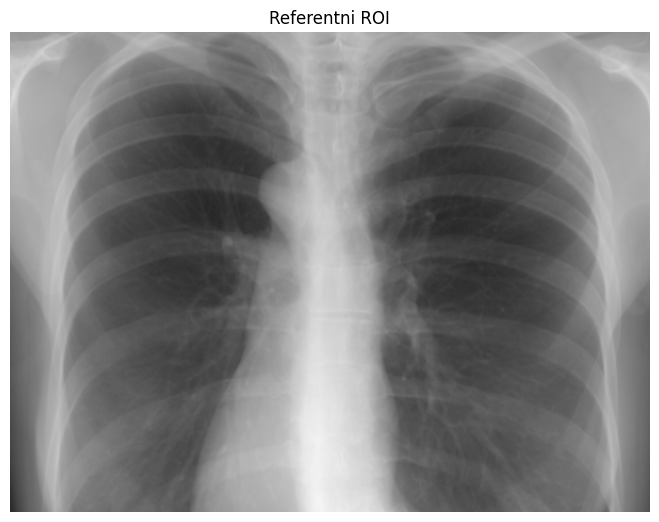

In [ ]:
# 1.2
v,k = r.shape
v1 = round(0.15*v)
v2 = round(0.75*v)
k1 = round(0.1*k)
k2 = round(0.9*k)
r_roi = r[v1-1:v2, k1-1:k2]
osum.disp_im(r_roi, title='Referentni ROI')

1.3 Interpolirati referentnu sliku u domenu koji definiše ROI, tako da se između svakog postojećeg piksela da unese dodatna lokacija. Koristiti bilinearnu metodu interpolacije.

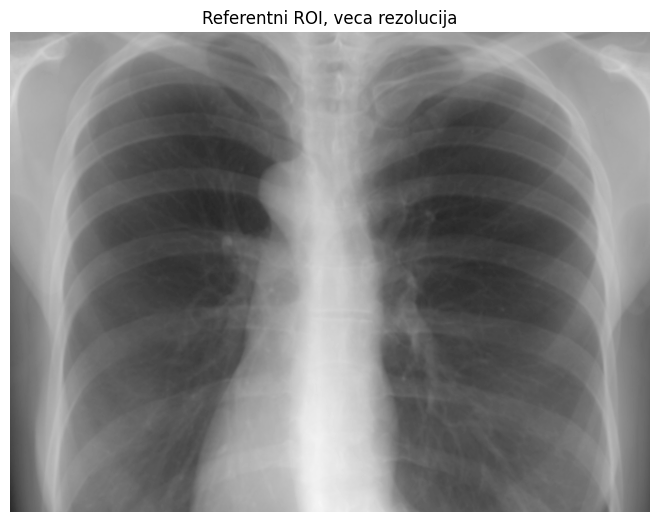

In [ ]:
# 1.3
nx = 0.5
ny = 0.5
[X, Y] = np.meshgrid(np.arange(k1-1, k2, nx), np.arange(v1-1, v2, ny))
X = np.float32(X) # funkcija cv2.remap zahteva koordinate u tipu float32
Y = np.float32(Y)
iR = cv2.remap(r, X, Y, interpolation=cv2.INTER_LINEAR)
osum.disp_im(iR, title='Referentni ROI, veca rezolucija')

1.4 Interpolirati referentnu sliku na indeksima (lokacijama) od 500 do 800 po x i y koordinati. Budući da ove lokacije izlaze iz prostora u kome je definisana referentna slika, potrebno je definisati ekstrapolacionu vrednost (npr. neka iznosi 100).

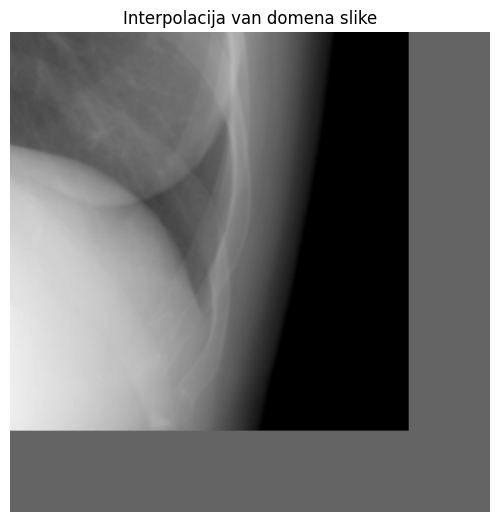

In [ ]:
# 1.4
[X, Y] = np.meshgrid(np.arange(500, 801), np.arange(500, 801))
X = np.float32(X)
Y = np.float32(Y)
iR = cv2.remap(r, X, Y, interpolation=cv2.INTER_LINEAR, borderValue=100)
osum.disp_im(iR, title='Interpolacija van domena slike')

1.5 Na domenu koji definiše ROI interpolirati referentnu i test sliku i izračunati koliko iznosi suma njihovih apsolutnih razlika.

In [ ]:
# 1.5
[X, Y] = np.meshgrid(np.arange(k1-1, k2), np.arange(v1-1, v2))
X = np.float32(X)
Y = np.float32(Y)
iR = cv2.remap(r, X, Y, interpolation=cv2.INTER_LINEAR)
iT = cv2.remap(t, X, Y, interpolation=cv2.INTER_LINEAR)
sAbs = np.sum(np.abs(iR-iT))

1.6 Kako bi se uhvatile razlike u strukturi, a ne u osvetljaju, ponoviti korak 1.5 sa z-normalizovanim slikama, izabrati proizvoljne parametre. Kako se promenila suma apsolutnih razlika?

In [ ]:
# 1.6
iRz = cv2.remap(osum.z_norm(r), X, Y, interpolation=cv2.INTER_LINEAR)
iTz = cv2.remap(osum.z_norm(t), X, Y, interpolation=cv2.INTER_LINEAR)
sAbsZ = np.sum(np.abs(iRz-iTz))

# 2. Perspektivne transformacije

2.1 Test slika je translirana u odnosu na referentnu, pa ju je potrebno transformisati (translirati) kako bi se geometrijski poklopila sa referentnom slikom. Zapravo se translira definisani region na test slici. Nakon odabiranja referentne slike potrebno je modifikovati koordinate [x, y] na kojima se odabira test slika tako da im se doda neki proizvoljni pomeraj, npr. (2,3). Pomeranje se mora uraditi odvojeno: x_tr = x + 2; y_tr = y + 3. Raditi sa z-normalizovanim slikama. Da li nakon translacije suma apsolutnih razlika između ROI-a referentne i test slike veća ili manja i šta taj rezultat znači?

In [ ]:
# 2.1
[x, y] = np.meshgrid(np.arange(k1-1, k2), np.arange(v1-1, v2))
x = np.float32(x)
y = np.float32(y)
iRz = cv2.remap(osum.z_norm(r), x, y, interpolation=cv2.INTER_LINEAR)

x_tr = X+2
y_tr = Y+3
iTt = cv2.remap(osum.z_norm(t), x_tr, y_tr, interpolation=cv2.INTER_LINEAR)

sAbst = np.sum(np.abs(iRz-iTt))

2.2 Za registraciju naše test slike na referentnu dovoljna nam je transformacija
translacijom, međutim postoje i druge perspektivne transformacije koje se mogu
primeniti u registraciji. Rotirati referentnu sliku prvo oko koordinatnog početka u gornjoj levoj tački slike, a zatim oko centra slike, za proizvoljni ugao. Koordinate slike nakon rotacije oko proizvoljne tačke za ugao 𝜃 u radijanima definisane su sledećom transformacijom:

\begin{align}
t_{crot}(p, r) = \begin{pmatrix} cos\theta & sin\theta \\ sin\theta & cos\theta \end{pmatrix}\begin{pmatrix} x - x_c \\ y - y_c \end{pmatrix} + \begin{pmatrix} x_c \\ y_c \end{pmatrix}
\end{align}

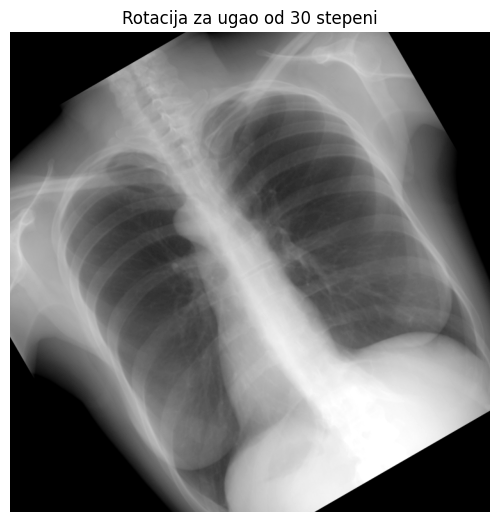

In [ ]:
# 2.2
th_deg = 30
th = th_deg*np.pi/180 # transformacija iz stepena u radijane
# koordinatni pocetak u gornjem levom uglu slike
# xc = 0
# tc = 0
# tacka u centru slike
xc = int(np.floor(r.shape[1]/2))
yc = int(np.floor(r.shape[0]/2))
[x, y] = np.meshgrid(np.arange(0, r.shape[1]), np.arange(0, r.shape[0]))
xr = np.cos(th)*(x-xc)-np.sin(th)*(y-yc)+xc
yr = np.sin(th)*(x-xc)+np.cos(th)*(y-yc)+yc
xr = np.float32(xr)
yr = np.float32(yr)
rr = cv2.remap(r, xr, yr, interpolation=cv2.INTER_LINEAR, borderValue=0)
osum.disp_im(rr, title='Rotacija za ugao od '+str(th_deg)+' stepeni')

2.3 Uveličati (umanjiti) sliku proizvoljnim faktorom s (uveličanje iznosi 1/s) prvo iz koordinatnog početka u gornjem levom uglu, a zatim iz centra slike. Transformacija uveličanjem je definisana na sledeći način:

\begin{align}
t_{zoom}(p, r) = \begin{pmatrix} s & 0 \\ 0 & s \end{pmatrix}\begin{pmatrix} x - x_c \\ y - y_c \end{pmatrix} + \begin{pmatrix} x_c \\ y_c \end{pmatrix}
\end{align}

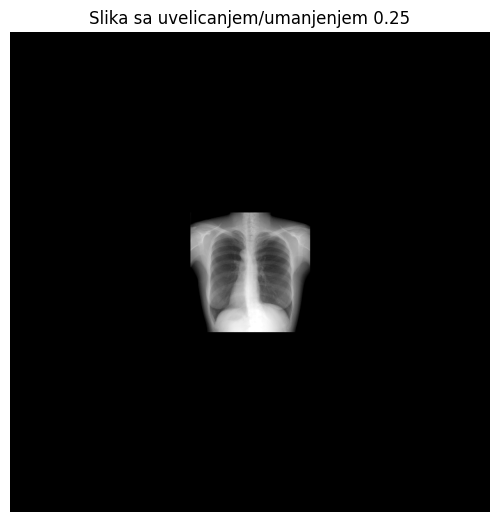

In [ ]:
# 2.3
s = 4
# s = 0.5
# koordinatni pocetak u gornjem levom uglu slike
# xc = 0
# yc = 0
# tacka u centru slike
xc = int(np.floor(r.shape[1]/2))
yc = int(np.floor(r.shape[0]/2))
xs = np.float32(s*(x-xc)+xc)
ys = np.float32(s*(y-yc)+yc)
rs = cv2.remap(r, xs, ys, interpolation=cv2.INTER_LINEAR, borderValue=0)
osum.disp_im(rs, title='Slika sa uvelicanjem/umanjenjem '+str(1/s))

# 3. Kruta registracija translacijom

3.1 Napraviti GUI preko koga korisnik može da definiše referentni ROI za registraciju klikom na gornji levi, a zatim na donji desni ćošak regiona od interesa. Prikazati izabrani region.

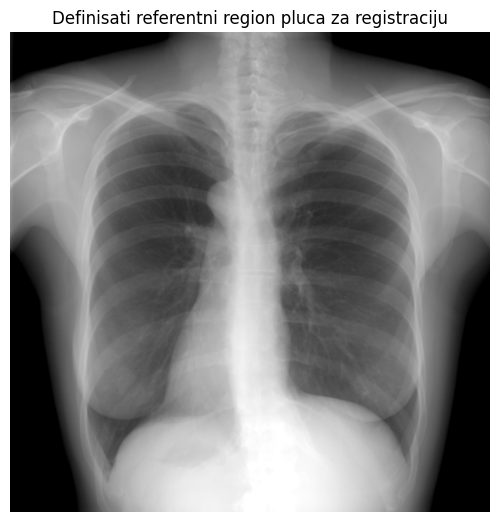

IndexError: ignored

In [ ]:
# 3.1
osum.disp_im(r, title='Definisati referentni region pluca za registraciju')
# potrebno je zakomentarisati svaku liniju plt.show() iznad da bi sledeca linija koda radila kako treba
refPts = plt.ginput(2)  # funkcija ocekuje koordinate 2 tacke koje unese korisnik

# potrebne su int vrednosti za indeksiranje
refPts1 = [int(np.round(pt)) for pt in refPts[0]]
refPts2 = [int(np.round(pt)) for pt in refPts[1]]
k1,v1 = refPts1
k2,v2 = refPts2
ref_roi = r[v1:v2+1, k1:k2+1]

osum.disp_im(ref_roi, title='Referenti ROI za registraciju')

3.2 Interpolirati z-normalizovanu referentnu sliku na izabranom regionu.


In [ ]:
# 3.2
[X, Y] = np.meshgrid(np.arange(k1, k2+1), np.arange(v1, v2+1))  # ne treba k1-1... jer ginput belezi koordinate pocevsi od 0
X = np.float32(X)
Y = np.float32(Y)
iR = cv2.remap(osum.z_norm(r), X, Y, interpolation=cv2.INTER_LINEAR, borderValue=0)

3.3 Naći optimalne pomeraje po x i y-osi tako da se minimalizuje suma apsolutnih razlika između slika. Isprobati pomeraje od -20 do 20 i po x i po y-osi. Za svaku kombinaciju pomeraja modifikovati koordinate [x, y] i na njima interpolirati test sliku, a zatim izračunati sumu apsolutnih razlika između z-normalizovane referentne slike I z-normalizovane translirane test slike. Sačuvati vrednosti objektivne funkcije u matricu d (iz koje na osnovu indeksa vrsta i kolona možemo doći do pomeraja po x i y-osi za koje je ostvarena određena vrednost objektivne funkcije).


In [ ]:
# 3.3
d = np.zeros((41, 41))
for tx in range(-20, 21):
    for ty in range(-20, 21):
        X_test = np.float32(X+tx)
        Y_test = np.float32(Y+ty)
        iT = cv2.remap(osum.z_norm(t), X_test, Y_test, interpolation=cv2.INTER_LINEAR, borderValue=0)
        d[ty+20, tx+20] = np.sum(np.abs(iR-iT))


3.4 Pronaći indekse na kojima se nalazi minimalna vrednost objektivne funkcije u matrici d i na osnovu njih izračunati optimalne pomeraje po x i y-osi. Proveriti da li je to u skladu sa izgledom test slike (gde se nalaze crne linije na obodu).

In [ ]:
# 3.4
i, j = np.where(d==d.min())
dMin = d[i,j]
x_opt = j-20
y_opt = i-20

3.5 Prikazati optimizacionu površinu.

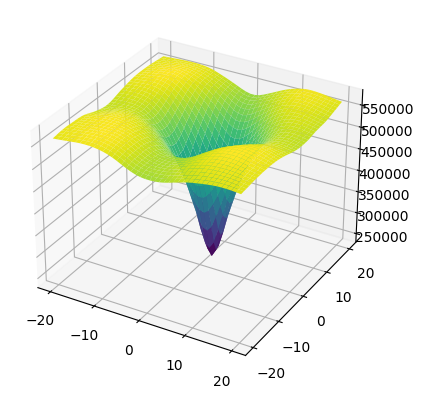

In [ ]:
# 3.5
fig = plt.figure()
ax = plt.axes(projection='3d')
[x, y] = np.meshgrid(np.arange(-20, 21), np.arange(-20, 21))  # pomeraji po x i y-osi
ax.plot_surface(x, y, d, cmap='viridis')